In [1]:

import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from captum.robust import PGD

# from model import vit_base_patch16_224
from timm.models import vit_base_patch16_224
import sys
sys.path.append('../')
from saliency import *
from utils import *
from plots import *

In [2]:
# model = vit_base_patch16_224(pretrained=True)
model = torch.load('/home/raza.imam/Documents/HC701B/Project/models/vit_base_patch16_224_in21k_test-accuracy_0.96_chest.pth')
model = model.cuda()

In [3]:
model.blocks[11].attn

Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

# 1. Generate (test) samples

In [35]:
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/testing/Tuberculosis/"
block = 11
plot=False
rand=True
random_state=None

attns_cln = [] #list of n test attentions
attns_adv = []
n_test_attns = 500
for i in range(n_test_attns):
    img, attn_cln, attn_adv, att_diff = test_img_attn(image_folder, block, model, plot=plot, rand=rand, random_state=random_state)
    attns_cln.append(attn_cln)
    attns_adv.append(attn_adv)

/home/raza.imam/.conda/envs/xaim/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [5]:
np.sum(attn_cln), np.sum(attn_adv)

(254.08598, 254.32603)

torch.Size([224, 224, 3])
(224, 224)
(224, 224)


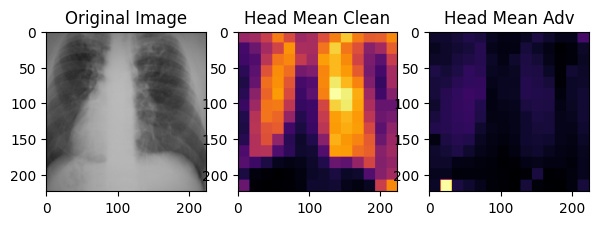

In [28]:
plt.figure(figsize=(7, 7))
text = ["Original Image", "Head Mean Clean", "Head Mean Adv"]
for i, fig in enumerate([img.squeeze(0).permute(2,1,0), attns_cln[0], attns_adv[0]]):
    print(fig.shape)
    plt.subplot(1, 3, i+1)
    plt.imshow(fig, cmap='inferno')
    plt.title(text[i])
plt.show()

# 2. Mean Attention of a block. For 2000 (train) images. 

In [7]:
from saliency import mean_attns_N_images
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/training/Tuberculosis/"
block = 11 #Select range from 0 to 11
N_images = 2000
N_random = False
device = "cuda"

print(f"On Block {block}")
mean_attns_cln, mean_attns_adv, mean_attns_diff, attentions_clean, attentions_adv = mean_attns_N_images(image_folder=image_folder, N_images=N_images, 
                                                                      block=block, model=model, N_random=N_random, device=device)


On Block 11
torch.Size([2000, 3, 224, 224])
mean_attns_cln.shape: (224, 224)
mean_attns_adv.shape: (224, 224)
mean_attns_diff.shape: (224, 224)


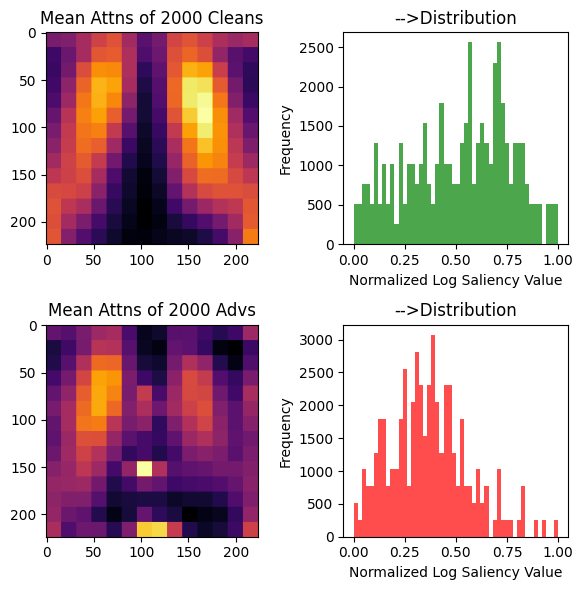

In [8]:
hist_plot(mean_attns_cln, mean_attns_adv, N_images)

In [9]:
np.mean(mean_attns_cln), np.mean(mean_attns_adv)

(0.0049512866, 0.0050050956)

# 3. Compare test sample attn with mean clean and adv attns

In [34]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
# Defining function
def classify_image_cos_similarity(test_attn, mean_attns_cln, mean_attns_adv):
    # Flatten the images to 1D arrays (if not already flattened)
    test_attn_flat = test_attn.flatten()
    mean_attns_cln_flat = mean_attns_cln.flatten()
    mean_attns_adv_flat = mean_attns_adv.flatten()
    # Calculate cosine similarities
    similarity_to_normal = cosine_similarity([test_attn_flat], [mean_attns_cln_flat])
    similarity_to_adversarial = cosine_similarity([test_attn_flat], [mean_attns_adv_flat])

    print(f"similarity_to_normal: {similarity_to_normal}", f"similarity_to_adversarial: {similarity_to_adversarial}")
    # Compare similarity scores and classify
    if similarity_to_normal > similarity_to_adversarial:
        return "Clean"
    else:
        return "Adversarial"

#__main__
# result = classify_image_cos_similarity(attn_adv, mean_attns_cln, mean_attns_adv)
# print(f"Test image is classified as: {result}")


similarity_to_normal: [[0.9778703]] similarity_to_adversarial: [[0.9745373]]
Test image is classified as: Clean


In [38]:
import numpy as np
from scipy.spatial.distance import euclidean
# Defining function
def classify_image_euclidean(test_attn, mean_attns_cln, mean_attns_adv):
    # Flatten the images to 1D arrays (if not already flattened)
    test_attn_flat = test_attn.flatten()
    mean_attns_cln_flat = mean_attns_cln.flatten()
    mean_attns_adv_flat = mean_attns_adv.flatten()
    # Calculate Euclidean distances
    distance_to_normal = euclidean(test_attn_flat, mean_attns_cln_flat)
    distance_to_adversarial = euclidean(test_attn_flat, mean_attns_adv_flat)
    
    print(f"distance_to_normal: {distance_to_normal}", f"distance_to_adversarial: {distance_to_adversarial}")
    # Compare distances and classify
    if distance_to_normal < distance_to_adversarial:
        return "Clean"
    else:
        return "Adversarial"

#__main__
result = classify_image_euclidean(attn_adv, mean_attns_cln, mean_attns_adv)
print(f"Test image is classified as: {result}")

distance_to_normal: 0.19316910207271576 distance_to_adversarial: 0.17306962609291077
Test image is classified as: Adversarial


In [43]:
num_test_images = len(attns_adv)
test_attns = attns_adv

classifications = []
# Test each test image
for test_attn in test_attns:
    result = classify_image_cos_similarity(test_attn, mean_attns_cln, mean_attns_adv)
    classifications.append(result)

# Calculate accuracy
true_labels = ["Adversarial"] * num_test_images  # Assuming all test images should be classified as "Normal"
accuracy = sum(1 for true, predicted in zip(true_labels, classifications) if true == predicted) / num_test_images
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


similarity_to_normal: [[0.7565423]] similarity_to_adversarial: [[0.7843322]]
similarity_to_normal: [[0.9669621]] similarity_to_adversarial: [[0.96417165]]
similarity_to_normal: [[0.7177941]] similarity_to_adversarial: [[0.7475476]]
similarity_to_normal: [[0.98187846]] similarity_to_adversarial: [[0.98952913]]
similarity_to_normal: [[0.94722176]] similarity_to_adversarial: [[0.96285105]]
similarity_to_normal: [[0.590355]] similarity_to_adversarial: [[0.60881305]]
similarity_to_normal: [[0.86389136]] similarity_to_adversarial: [[0.9190663]]
similarity_to_normal: [[0.97528964]] similarity_to_adversarial: [[0.9757184]]
similarity_to_normal: [[0.9826299]] similarity_to_adversarial: [[0.9947767]]
similarity_to_normal: [[0.94917136]] similarity_to_adversarial: [[0.95242906]]
similarity_to_normal: [[0.9871658]] similarity_to_adversarial: [[0.9842659]]
similarity_to_normal: [[0.978698]] similarity_to_adversarial: [[0.9923006]]
similarity_to_normal: [[0.874173]] similarity_to_adversarial: [[0.91